<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/pytorch/blob/main/conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics.classification
import torchvision as vision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import SGD,Adam
from torch.utils.data import DataLoader,Dataset, random_split
from torchmetrics.classification import BinaryConfusionMatrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torchmetrics 
from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix,\
                                BinaryPrecision,BinaryRecall,BinaryROC,BinaryAUROC

In [25]:
transform = transforms.ToTensor()
dataset=ImageFolder("images",transform=transform)

In [26]:


class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # input is (*,3,512,512)
    self.model=nn.Sequential(
      nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3),
      
    # input is (*,32,510,510)
      nn.MaxPool2d(kernel_size=(2,2)),
# input is (*,32,255,255)
      nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
      nn.ReLU(),
    # input is (*,64,253,253)
      nn.MaxPool2d(kernel_size=(2,2)),
    # input is (*,64,126,126)
      nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3),
      nn.ReLU(),
    # input is (*,128,124,124)
      nn.MaxPool2d(kernel_size=(2,2)),
    # input is (*,128,62,62)
      nn.Flatten(),
    # input is (*,128x62x62)
      nn.Linear(in_features=62*62*128,out_features=1)

    )
   
  def forward(self,x):
    return self.model(x)

In [27]:
device='cuda' if torch.cuda.is_available() else 'cpu'


In [28]:

def get_accuracy(dataloader,model):
  accuracy=BinaryAccuracy().to(device)
#   total=len(dataloader)*dataloader.batch_size
#   correct=0
  for imgs,labels in dataloader:
    imgs,labels=imgs.to(device),labels.to(device)
    outputs=model(imgs)
  # torchmetrics BinaryAccuracy automatically applies sigmoid
  # and threshold of (default) 0.5
    accuracy.update(outputs.squeeze(),labels)

  return accuracy.compute().item()

In [29]:



k=3
acc_v=np.empty(k)
auroc_v=np.empty(k)
precision_v=np.empty(k)
recall_v=np.empty(k)
roc_v=[]
conmat_v=[]

In [30]:
for v in range(k):
    accuracy=BinaryAccuracy().to(device)
    conmat=BinaryConfusionMatrix().to(device)
    precision=BinaryPrecision().to(device)
    recall=BinaryRecall().to(device=device)
    roc=BinaryROC().to(device=device)
    auroc=BinaryAUROC().to(device=device)
    print(f'Fold {v}')
    print('---------------------')
    print('---------------------')
    model=Net().to(device)
    optimizer=Adam(model.parameters())
    loss_fn=nn.BCEWithLogitsLoss()
    epochs=30
    dataset_train,dataset_test=random_split(dataset,lengths=[0.8,0.2])
    loader_train=DataLoader(dataset_train,batch_size=32,shuffle=True,num_workers=2)
    loader_test=DataLoader(dataset_test,batch_size=16,shuffle=False)

    for epoch in range(epochs):
      loop=tqdm(loader_train)
      loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
      epoch_loss=0.
      for (imgs,labels) in loop:
        optimizer.zero_grad()
        imgs=imgs.cuda()
        labels=labels.cuda()
        outputs=model(imgs)
        loss=loss_fn(outputs.squeeze(),labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss=0.9*epoch_loss+0.1*loss.item()
        loop.set_postfix(loss=epoch_loss)
    
      acc=get_accuracy(loader_test,model)
      print(acc)
    for data in loader_test:
      imgs,labels=data
      imgs=imgs.cuda()
      labels=labels.cuda()
      outputs=model(imgs).squeeze()

      accuracy.update(outputs,labels)
      recall.update(outputs,labels)
      roc.update(outputs,labels)
      auroc.update(outputs,labels)
      precision.update(outputs,labels)
      conmat.update(outputs,labels)

    acc_val=accuracy.compute()
    x=conmat.compute().cpu().numpy()
    precision_val=precision.compute()
    recall_val=recall.compute()
    auroc_val=auroc.compute()
    roc_val=roc.compute()
    a=[z.cpu().numpy() for z in roc_val[:2]]
    roc_v.append((roc_val[0].cpu().numpy(),roc_val[1].cpu().numpy()))
    acc_v[v]=acc_val.cpu().numpy()
    auroc_v[v]=auroc_val.cpu().numpy()
    precision_v[v]=precision_val
    recall_v[v]=recall_val
    conmat_v.append(x)
    print(f'accuracy={acc_val} precision={precision_val}, recall={recall_val},auroc={auroc_val}')

Fold 0
---------------------
---------------------


Epoch [1/30]: 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, loss=0.491] 


0.625


Epoch [2/30]: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s, loss=0.321] 


0.4375


Epoch [3/30]: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s, loss=0.266] 


0.71875


Epoch [4/30]: 100%|██████████| 5/5 [00:00<00:00,  6.33it/s, loss=0.264] 


0.78125


Epoch [5/30]: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s, loss=0.27]  


0.625


Epoch [6/30]: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s, loss=0.209] 


0.78125


Epoch [7/30]: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s, loss=0.166] 


0.78125


Epoch [8/30]: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s, loss=0.198] 


0.84375


Epoch [9/30]: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s, loss=0.199] 


0.8125


Epoch [10/30]: 100%|██████████| 5/5 [00:00<00:00,  6.24it/s, loss=0.201] 


0.8125


Epoch [11/30]: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s, loss=0.178] 


0.78125


Epoch [12/30]: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s, loss=0.159] 


0.71875


Epoch [13/30]: 100%|██████████| 5/5 [00:00<00:00,  6.23it/s, loss=0.17]  


0.8125


Epoch [14/30]: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s, loss=0.146] 


0.8125


Epoch [15/30]: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s, loss=0.146] 


0.8125


Epoch [16/30]: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s, loss=0.151] 


0.78125


Epoch [17/30]: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s, loss=0.107] 


0.8125


Epoch [18/30]: 100%|██████████| 5/5 [00:00<00:00,  5.98it/s, loss=0.116] 


0.8125


Epoch [19/30]: 100%|██████████| 5/5 [00:00<00:00,  6.19it/s, loss=0.111] 


0.8125


Epoch [20/30]: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s, loss=0.118] 


0.8125


Epoch [21/30]: 100%|██████████| 5/5 [00:00<00:00,  6.33it/s, loss=0.131] 


0.8125


Epoch [22/30]: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s, loss=0.13]  


0.78125


Epoch [23/30]: 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, loss=0.191] 


0.75


Epoch [24/30]: 100%|██████████| 5/5 [00:00<00:00,  6.34it/s, loss=0.121] 


0.78125


Epoch [25/30]: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s, loss=0.126] 


0.8125


Epoch [26/30]: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s, loss=0.168] 


0.78125


Epoch [27/30]: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s, loss=0.17]  


0.8125


Epoch [28/30]: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s, loss=0.116] 


0.78125


Epoch [29/30]: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s, loss=0.102] 


0.8125


Epoch [30/30]: 100%|██████████| 5/5 [00:00<00:00,  6.33it/s, loss=0.111] 


0.78125
accuracy=0.78125 precision=0.8823529481887817, recall=0.75,auroc=0.9041666388511658
Fold 1
---------------------
---------------------


Epoch [1/30]: 100%|██████████| 5/5 [00:00<00:00,  6.44it/s, loss=0.391] 


0.5


Epoch [2/30]: 100%|██████████| 5/5 [00:00<00:00,  6.21it/s, loss=0.296] 


0.5625


Epoch [3/30]: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s, loss=0.274] 


0.59375


Epoch [4/30]: 100%|██████████| 5/5 [00:00<00:00,  6.44it/s, loss=0.321] 


0.6875


Epoch [5/30]: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s, loss=0.259] 


0.6875


Epoch [6/30]: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s, loss=0.248] 


0.875


Epoch [7/30]: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s, loss=0.231] 


0.9375


Epoch [8/30]: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s, loss=0.207] 


0.84375


Epoch [9/30]: 100%|██████████| 5/5 [00:00<00:00,  6.22it/s, loss=0.2]   


0.9375


Epoch [10/30]: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s, loss=0.187] 


0.9375


Epoch [11/30]: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s, loss=0.268] 


0.90625


Epoch [12/30]: 100%|██████████| 5/5 [00:00<00:00,  6.29it/s, loss=0.249]


0.8125


Epoch [13/30]: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s, loss=0.189] 


0.875


Epoch [14/30]: 100%|██████████| 5/5 [00:00<00:00,  6.29it/s, loss=0.221] 


0.90625


Epoch [15/30]: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s, loss=0.173] 


0.90625


Epoch [16/30]: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s, loss=0.192] 


0.9375


Epoch [17/30]: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s, loss=0.17]  


0.84375


Epoch [18/30]: 100%|██████████| 5/5 [00:00<00:00,  6.39it/s, loss=0.137] 


0.9375


Epoch [19/30]: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s, loss=0.199] 


0.90625


Epoch [20/30]: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s, loss=0.136] 


0.78125


Epoch [21/30]: 100%|██████████| 5/5 [00:00<00:00,  6.34it/s, loss=0.188] 


0.875


Epoch [22/30]: 100%|██████████| 5/5 [00:00<00:00,  6.34it/s, loss=0.152] 


0.9375


Epoch [23/30]: 100%|██████████| 5/5 [00:00<00:00,  6.15it/s, loss=0.166] 


0.875


Epoch [24/30]: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s, loss=0.246] 


0.90625


Epoch [25/30]: 100%|██████████| 5/5 [00:00<00:00,  6.29it/s, loss=0.187] 


0.84375


Epoch [26/30]: 100%|██████████| 5/5 [00:00<00:00,  6.20it/s, loss=0.206] 


0.90625


Epoch [27/30]: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s, loss=0.254] 


0.875


Epoch [28/30]: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s, loss=0.16]  


0.875


Epoch [29/30]: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s, loss=0.222] 


0.9375


Epoch [30/30]: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s, loss=0.152] 


0.9375
accuracy=0.9375 precision=0.9375, recall=0.9375,auroc=0.97265625
Fold 2
---------------------
---------------------


Epoch [1/30]: 100%|██████████| 5/5 [00:00<00:00,  6.33it/s, loss=0.453] 


0.53125


Epoch [2/30]: 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, loss=0.293] 


0.46875


Epoch [3/30]: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s, loss=0.293] 


0.6875


Epoch [4/30]: 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, loss=0.25]  


0.5


Epoch [5/30]: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s, loss=0.205] 


0.8125


Epoch [6/30]: 100%|██████████| 5/5 [00:00<00:00,  6.29it/s, loss=0.234] 


0.78125


Epoch [7/30]: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s, loss=0.165] 


0.78125


Epoch [8/30]: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s, loss=0.191] 


0.71875


Epoch [9/30]: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s, loss=0.166] 


0.8125


Epoch [10/30]: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s, loss=0.157] 


0.8125


Epoch [11/30]: 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, loss=0.259] 


0.8125


Epoch [12/30]: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s, loss=0.189] 


0.75


Epoch [13/30]: 100%|██████████| 5/5 [00:00<00:00,  6.23it/s, loss=0.286] 


0.75


Epoch [14/30]: 100%|██████████| 5/5 [00:00<00:00,  6.29it/s, loss=0.172] 


0.71875


Epoch [15/30]: 100%|██████████| 5/5 [00:00<00:00,  6.17it/s, loss=0.199] 


0.71875


Epoch [16/30]: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s, loss=0.156] 


0.78125


Epoch [17/30]: 100%|██████████| 5/5 [00:00<00:00,  6.40it/s, loss=0.116] 


0.8125


Epoch [18/30]: 100%|██████████| 5/5 [00:00<00:00,  6.21it/s, loss=0.119] 


0.8125


Epoch [19/30]: 100%|██████████| 5/5 [00:00<00:00,  6.19it/s, loss=0.153] 


0.71875


Epoch [20/30]: 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, loss=0.135] 


0.84375


Epoch [21/30]: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s, loss=0.164] 


0.75


Epoch [22/30]: 100%|██████████| 5/5 [00:00<00:00,  6.39it/s, loss=0.146] 


0.71875


Epoch [23/30]: 100%|██████████| 5/5 [00:00<00:00,  6.40it/s, loss=0.14]  


0.8125


Epoch [24/30]: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s, loss=0.151] 


0.75


Epoch [25/30]: 100%|██████████| 5/5 [00:00<00:00,  6.33it/s, loss=0.133] 


0.8125


Epoch [26/30]: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s, loss=0.124] 


0.84375


Epoch [27/30]: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s, loss=0.108] 


0.71875


Epoch [28/30]: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s, loss=0.107] 


0.84375


Epoch [29/30]: 100%|██████████| 5/5 [00:00<00:00,  6.21it/s, loss=0.107] 


0.78125


Epoch [30/30]: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s, loss=0.13]  


0.84375
accuracy=0.84375 precision=0.9166666865348816, recall=0.7333333492279053,auroc=0.8666666746139526


In [31]:
print(f'accuracy_mean={acc_v.mean()}')
print(f'precision_mean={precision_v.mean()}')
print(f'recall_mean={recall_v.mean()}')
print(f'auroc_mean={auroc_v.mean()}')
tpr=roc_v[0][0]
fpr=roc_v[0][1]
for i in range(1,k):
  tpr+=roc_v[i][0]
  fpr+=roc_v[i][1]
tpr/=k
fpr/=k

#mat=np.empty((2,2))
mat=conmat_v[0]
for i in range(1,k):
  mat+=conmat_v[i]
mat=mat/k

accuracy_mean=0.8541666666666666
precision_mean=0.9121732115745544
recall_mean=0.8069444497426351
auroc_mean=0.9144965211550394


In [36]:
print(mat)

[[13.66666667  1.33333333]
 [ 3.33333333 13.66666667]]


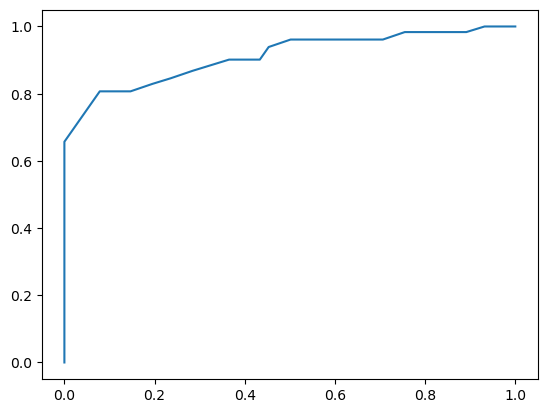

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(tpr,fpr)